# GAN

GANでMNISTを生成する。  
DeepConvolutionalじゃないGAN。なるべくシンプルな実装を目指す。

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm

batch_size = 64
nz = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MNIST

In [2]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_X = next(iter(dataloader))[0]
w, h = sample_X.shape[2:]
img_size = w * h
print("batch shape:", sample_X.shape)
print("width:", w)
print("height:", h)
print("image size:", img_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


## Discriminator

全結合とReLUで構築

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(), # 1x28x28 -> 784
            self._linear(img_size, 512),
            self._linear(512, 128),
            nn.Linear(128, 1),
            nn.Sigmoid(), # 0~1に
        )

    def _linear(self, input_size, output_size):
        """全結合とReLU"""
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

## Generator

全結合とReLUとバッチ正規化で構築

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, img_size),
            nn.Sigmoid()
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        y = y.view(-1, 1, w, h) # 784 -> 1x28x28
        return y

## 学習

In [5]:
# ノイズを生成
def make_noise(batch_size):
    return torch.randn(batch_size, nz, device=device)

# 画像描画
def write(netG, n_rows=1, n_cols=8, size=64):
    z = make_noise(n_rows*n_cols)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_cols)
    img = transforms.functional.to_pil_image(img)
    display(img)

今回は本物を0, 偽物を1とする。  
Generatorが生成した偽物をDiscriminatorで判定したときに0になるように学習する。

**0に近づきたい = 小さくしたい** と捉えられるので、Discriminatorの出力をそのまま**損失**として扱って逆伝播を行う

ただ一般的には、Discriminatorの出力を交差エントロピーに入れたものを損失として扱う。その方が損失が指数関数になるので学習が上手く進む（多分）。  
交差エントロピーを使うときは、0, 1の値はどっちでもいい。本物を1, 偽物を0とすることが多い気がする。

In [6]:
real_labels = torch.zeros(batch_size, 1).to(device) # 正解のラベル
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物のラベル
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1, progress=True, print_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        lossD_list = []
        lossG_list = []
        for X, _ in tqdm(dataloader, disable=not progress):
            X = X.to(device)

            # 勾配をリセット
            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習
            z = make_noise(batch_size) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake) # 偽物を判定
            pred_real = netD(X) # 本物を判定
            loss_fake = criterion(pred_fake, fake_labels) # 偽物の誤差（上手く判定できたか）
            loss_real = criterion(pred_real, real_labels) # 本物の誤差
            lossD = loss_fake + loss_real # 誤差の合計
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake) # 偽物を判定
            lossG = pred.sum() # 和をとる
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        if print_interval and epoch % print_interval == 0:
            print(f'{epoch:>3}epoch | lossD: {lossD}, lossG: {lossG}')
        if write_interval and epoch % write_interval == 0:
            write(netG)

  1epoch | lossD: 0.028963718563318253, lossG: 63.43583297729492


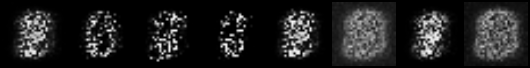

  2epoch | lossD: 0.009654196910560131, lossG: 63.68519592285156


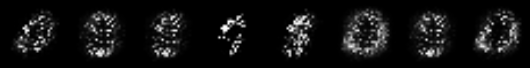

  3epoch | lossD: 0.05716589465737343, lossG: 63.48046112060547


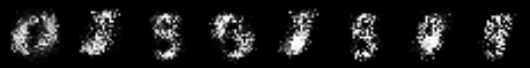

  4epoch | lossD: 0.07564389705657959, lossG: 61.640174865722656


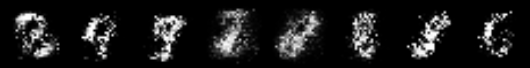

  5epoch | lossD: 0.16677045822143555, lossG: 60.78288269042969


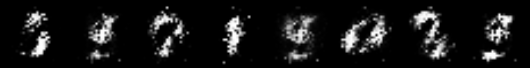

In [7]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

train(netD, netG, optimD, optimG, n_epochs, 1, False)

いい感じに成長していそうなので、このまま30回学習させる

  1epoch | lossD: 0.10003699362277985, lossG: 61.924659729003906
  2epoch | lossD: 0.16847634315490723, lossG: 61.61968994140625
  3epoch | lossD: 0.1762424111366272, lossG: 61.80844497680664
  4epoch | lossD: 0.2699550986289978, lossG: 60.39994812011719
  5epoch | lossD: 0.36954349279403687, lossG: 57.61738586425781


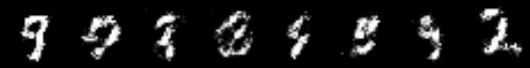

  6epoch | lossD: 0.3095152974128723, lossG: 57.542442321777344
  7epoch | lossD: 0.30427324771881104, lossG: 57.48322296142578
  8epoch | lossD: 0.7069735527038574, lossG: 50.118743896484375
  9epoch | lossD: 0.7861781120300293, lossG: 51.81081008911133
 10epoch | lossD: 0.6245485544204712, lossG: 51.32354736328125


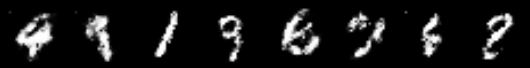

 11epoch | lossD: 0.7233791351318359, lossG: 49.54179763793945
 12epoch | lossD: 0.7554690837860107, lossG: 50.07997131347656
 13epoch | lossD: 0.7746788263320923, lossG: 48.14771270751953
 14epoch | lossD: 0.788260817527771, lossG: 46.35505676269531
 15epoch | lossD: 0.903372049331665, lossG: 47.56683349609375


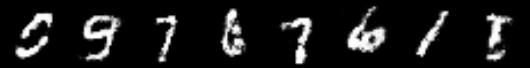

 16epoch | lossD: 0.7667723894119263, lossG: 47.27935028076172
 17epoch | lossD: 0.8548305034637451, lossG: 44.06669616699219
 18epoch | lossD: 0.8780440092086792, lossG: 45.515708923339844
 19epoch | lossD: 0.8831883668899536, lossG: 45.5047492980957
 20epoch | lossD: 1.0419878959655762, lossG: 44.99326705932617


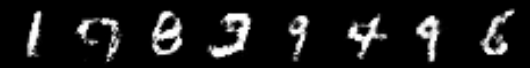

 21epoch | lossD: 0.9382543563842773, lossG: 44.19329833984375
 22epoch | lossD: 0.9314603209495544, lossG: 47.60102844238281
 23epoch | lossD: 0.8965047597885132, lossG: 47.99530792236328
 24epoch | lossD: 0.9904032945632935, lossG: 46.414306640625
 25epoch | lossD: 1.0708621740341187, lossG: 43.818790435791016


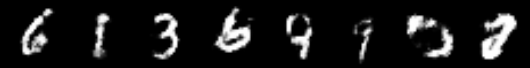

 26epoch | lossD: 1.002791404724121, lossG: 45.21208572387695
 27epoch | lossD: 0.9536371231079102, lossG: 43.879981994628906
 28epoch | lossD: 0.8268580436706543, lossG: 45.8182258605957
 29epoch | lossD: 1.077519416809082, lossG: 47.57958221435547
 30epoch | lossD: 1.1305723190307617, lossG: 41.28942108154297


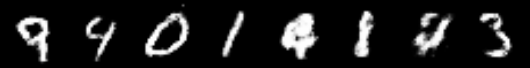

In [8]:
train(netD, netG, optimD, optimG, 30, 5, False)

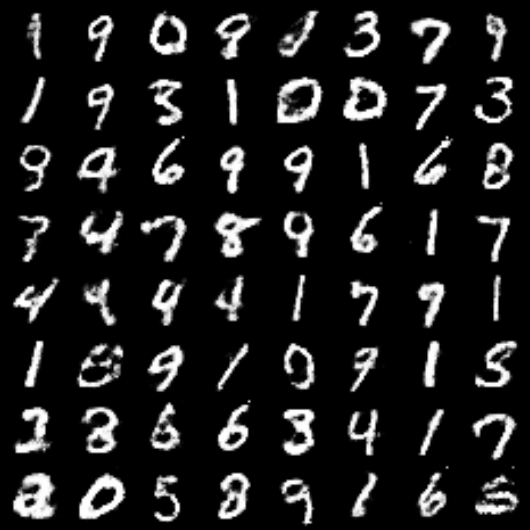

In [9]:
write(netG, 8)

上手く学習できた